# APS360 Group Project

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import os

In [19]:
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


## Dataset Loading

In [20]:
FONT_DATASET_PATH = "./fonts_image_dataset"

def custom_collate_fn(batch):
    
    # Use the default collate function to batch the data (images)
    batch = default_collate(batch)
    images, labels = batch
    
    # Apply one-hot encoding to the labels
    labels = F.one_hot(labels)

    return images, labels

def load_dataset(dataset_path, batch_size):

    # Convert the images to tensors and normalize them
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
    gestures_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform=transform)

    # Create a list of indices for all the images in the dataset
    dataset_size = len(gestures_dataset)
    indices = list(range(dataset_size))

    np.random.seed(0)
    np.random.shuffle(indices)

    # Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
    split1 = int(0.6 * dataset_size)
    split2 = int(0.8 * dataset_size)
    train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

    # Create a sampler for the training, validation, and testing sets
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, gestures_dataset.classes


## Baseline Model

In [21]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


## Training & Output Visualization

In [22]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, criterion, calculate_error = True):
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
                
            # Forward pass
            outputs = net(inputs)
            
            # Calculate the statistics
            total_err += total_error(outputs, labels)
            total_loss += criterion(outputs, labels.float()).item()
            total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss


def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate,weight_decay=1e-3)

    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_error = 1
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
        
        # Save the best model
        if train_err[epoch] <= min_validation_error:
            min_validation_error = train_err[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_baseline_model")

    print('Finished Training')

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_err.csv", train_err)
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_err.csv", val_err)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8128333333333333, Train loss: 2.305906539267682 | Validation err: 0.759, Validation loss: 1.9713061302900314
Epoch 2: Train err: 0.698, Train loss: 1.883566640793009 | Validation err: 0.7225, Validation loss: 1.8519926220178604
Epoch 3: Train err: 0.6415, Train loss: 1.7155873597936426 | Validation err: 0.7135, Validation loss: 1.819646418094635
Epoch 4: Train err: 0.6285, Train loss: 1.6657938703577568 | Validation err: 0.705, Validation loss: 1.8026059940457344
Epoch 5: Train err: 0.547, Train loss: 1.477757674582461 | Validation err: 0.6775, Validation loss: 1.8533382341265678
Epoch 6: Train err: 0.5035, Train loss: 1.359442634785429 | Validation err: 0.6745, Validation loss: 1.8660404086112976
Epoch 7: Train err: 0.4515, Train loss: 1.2267590761184692 | Validation err: 0.677, Validation loss: 1.9864643812179565
Epoch 8: Train err: 0.4553333333333333, Train loss: 1.2907080675693268 | Validation err: 0.671, Validation loss: 2.

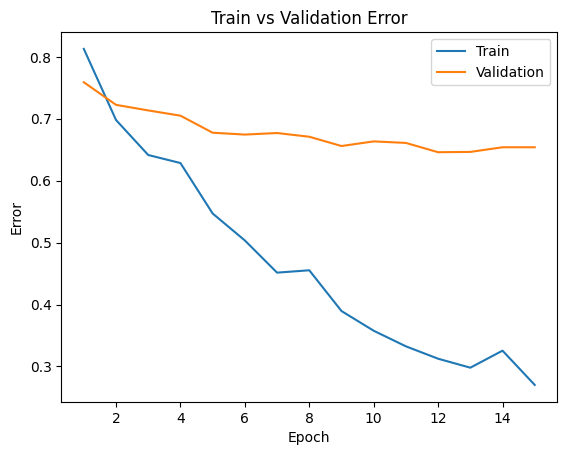

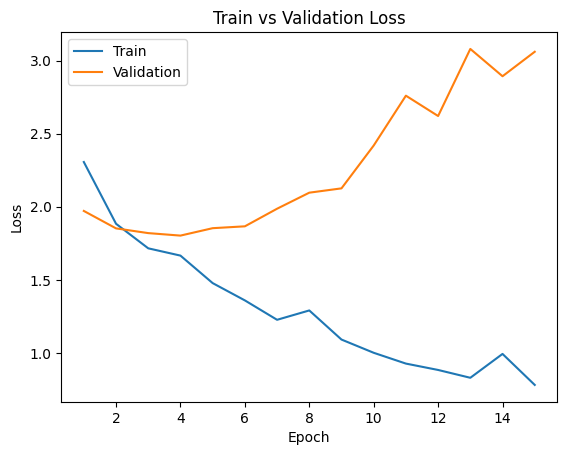

In [23]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
net = BaselineModel().to(device)
train_net(net, "baseline_model", learning_rate=0.01, num_epochs=15)
plot_training_curve("baseline_model")

## Primary Model 1

In [28]:
class PrimaryModel1(nn.Module):
    def __init__(self):
        super(PrimaryModel1, self).__init__() 
        self.conv1 = nn.Conv2d(1, 8, 3) 
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*26*26, 256)
        self.fc2 = nn.Linear(256,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, 32*26*26)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class AutoEncoder1(nn.Module):
    def __init__(self):
        super(AutoEncoder1,self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.ConvTranspose2d(32, 16, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16, 8, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8, 1, 3, 2, 1, 1)
        self.dropout = nn.Dropout(0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) 

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        x = F.sigmoid(x)
        return x

In [29]:
def TrainAutoEncoder(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay=1e-3)
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
          img,_ = data
          img = img.to(device)
          recon = net(img)
          loss = criterion(recon,img)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        print('epoch = {}, loss = {:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch,img,recon),)
    return outputs

In [30]:
AutoEncoder1 = AutoEncoder1().to(device)
max_epochs = 20
outputs = TrainAutoEncoder(AutoEncoder1, 'AutoEncoder1', num_epochs= max_epochs )

Done Loading Data
epoch = 1, loss = 0.0634
epoch = 2, loss = 0.0564
epoch = 3, loss = 0.0517
epoch = 4, loss = 0.0478
epoch = 5, loss = 0.0422
epoch = 6, loss = 0.0489
epoch = 7, loss = 0.0419
epoch = 8, loss = 0.0373
epoch = 9, loss = 0.0421
epoch = 10, loss = 0.0400
epoch = 11, loss = 0.0381
epoch = 12, loss = 0.0352
epoch = 13, loss = 0.0421
epoch = 14, loss = 0.0448
epoch = 15, loss = 0.0366
epoch = 16, loss = 0.0385
epoch = 17, loss = 0.0323
epoch = 18, loss = 0.0369
epoch = 19, loss = 0.0399
epoch = 20, loss = 0.0363


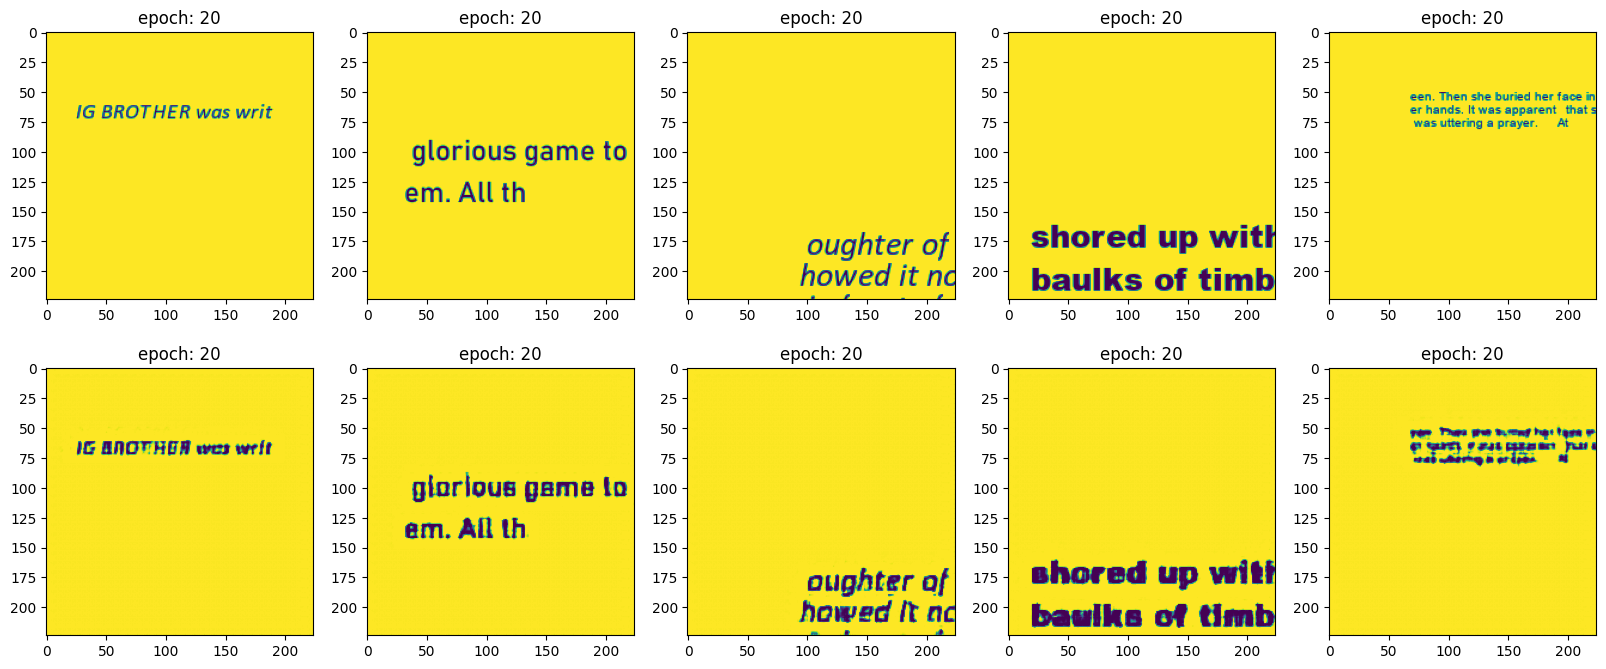

In [31]:
max_epochs = 20
plt.figure(figsize = (20,8))
img = outputs[max_epochs-1][1].cpu().detach().numpy()
recon = outputs[max_epochs-1][2].cpu().detach().numpy()
for i,item in enumerate(img):
    if i>=5:break
    plt.subplot(2,5,i+1)
    plt.imshow(item[0])
    plt.title("epoch: {}".format(str(max_epochs)))
for i,item in enumerate(recon):
    if i>=5:break
    plt.subplot(2,5,5+i+1)
    plt.imshow(item[0])
    plt.title("epoch: {}".format(str(max_epochs)))


Done Loading Data
Starting Training
Epoch 1: Train err: 0.8921666666666667, Train loss: 2.344351900384781 | Validation err: 0.8815, Validation loss: 2.2863952666521072
Epoch 2: Train err: 0.8506666666666667, Train loss: 2.2518145835145993 | Validation err: 0.842, Validation loss: 2.1882781982421875
Epoch 3: Train err: 0.8055, Train loss: 2.099980098135928 | Validation err: 0.7855, Validation loss: 2.0225356817245483
Epoch 4: Train err: 0.7465, Train loss: 1.95583879186752 | Validation err: 0.7445, Validation loss: 1.9019997715950012
Epoch 5: Train err: 0.7035, Train loss: 1.8344694350628143 | Validation err: 0.6995, Validation loss: 1.7854103744029999
Epoch 6: Train err: 0.6376666666666667, Train loss: 1.6947705111605056 | Validation err: 0.6095, Validation loss: 1.6312383860349655
Epoch 7: Train err: 0.5741666666666667, Train loss: 1.5454739535108526 | Validation err: 0.5285, Validation loss: 1.462221123278141
Epoch 8: Train err: 0.5073333333333333, Train loss: 1.3722080550295241 | Va

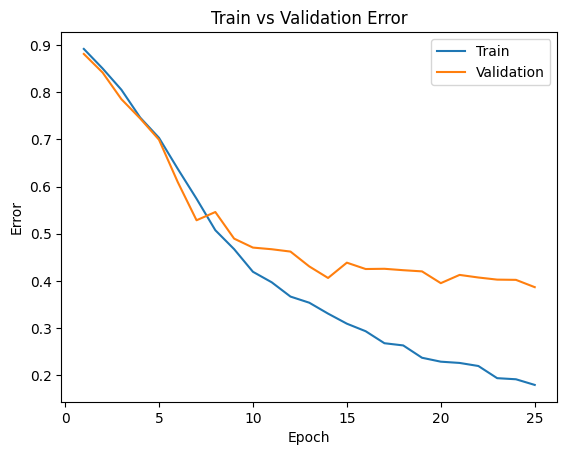

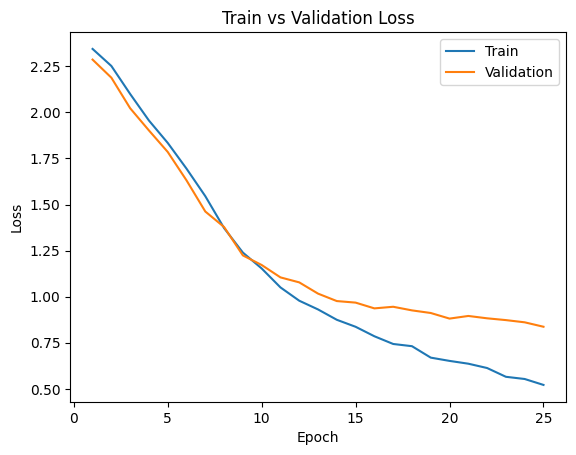

In [32]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
PrimaryModel1  = PrimaryModel1().to(device)
train_net(PrimaryModel1, "PrimaryModel1", learning_rate=0.0001, num_epochs=25)
plot_training_curve("PrimaryModel1")

Done Loading Data
1236 correct out of 2000 the accuracy is 61.80%


<function matplotlib.pyplot.show(close=None, block=None)>

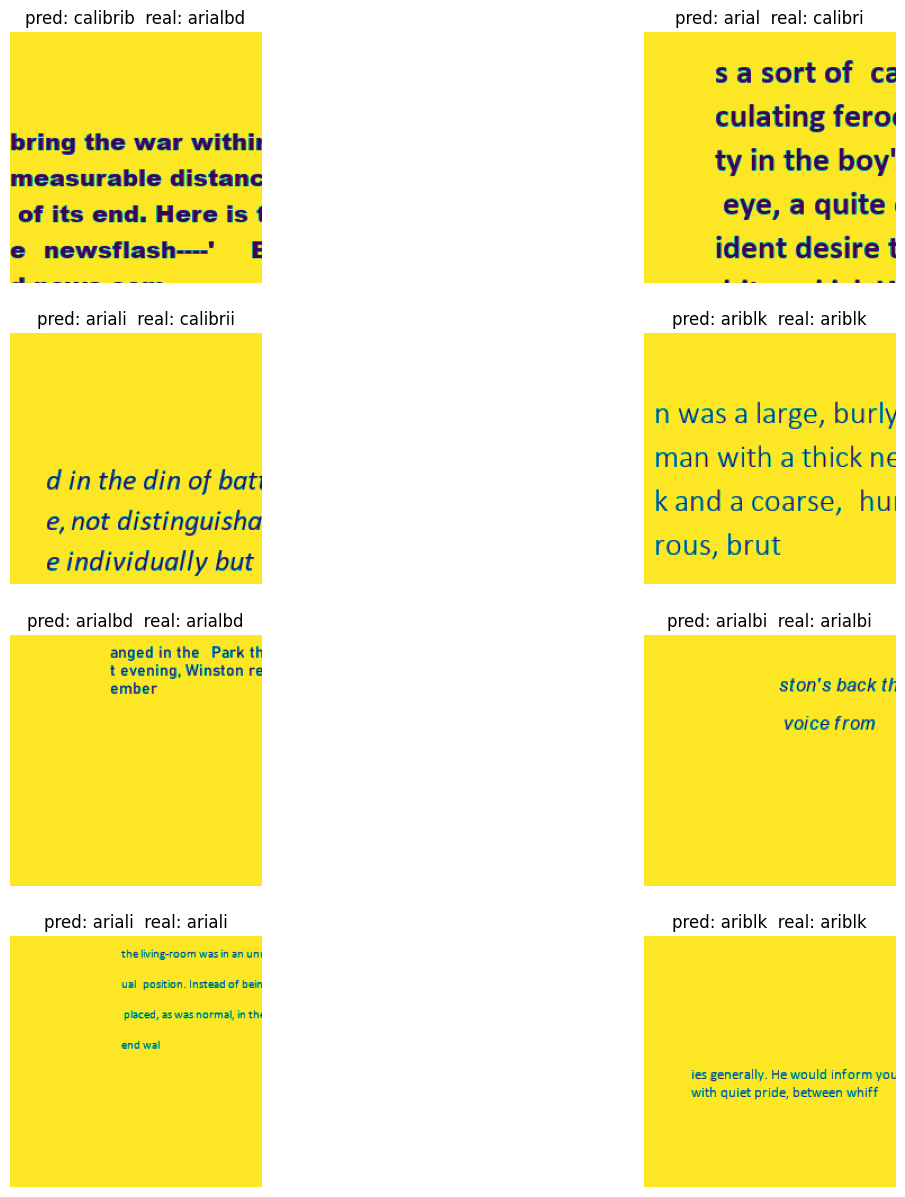

In [33]:
x,y,test_loader, classes = load_dataset(FONT_DATASET_PATH,batch_size = 128)

correct, total = 0,0
predictions =[]
truths = []

for i, (inputs, labels) in enumerate(test_loader, 0):
    inputs, labels = inputs.to(device), labels.to(device)
    t =0
    c = 0
    count = 0 

    abc, ind = torch.max(labels,1)
    PrimaryModel1.eval()
    with torch.no_grad():
        outputs = PrimaryModel1(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            pred_label = classes[predicted[i]]
            predictions.append(pred_label)
            ground_truth = classes[ind[i]]
            truths.append(ground_truth)
            if pred_label == ground_truth:
                c +=1
            t += 1

    correct += c
    total += t
print("%d correct out of %d the accuracy is %.2lf" %(correct,total,(correct/total)*100) +'%')

dataiter = iter(test_loader)
images,labels = next(dataiter)

f = plt.figure(figsize=(15,15))
for i in range(8):
    img = images[i]
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5

    f.add_subplot(4, 2, i+1)
    plt.axis('off')
    plt.title("pred: %s  real: %s" %  (predictions[i], truths[i]) )
    plt.imshow(img)
plt.show

## Primary Model 2

In [37]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x, training=False):
        x_initial = x
        x = self.pool(F.relu(self.conv1(x))) #32x112x112
        x = self.pool(F.relu(self.conv2(x))) #64x56x56
        x = self.pool(F.relu(self.conv3(x))) #128x28x28

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)) 
        x = F.relu(self.conv6(x))
        return x


class PrimaryModel2(nn.Module):
    def __init__(self, autoEncoder):
        super(PrimaryModel2, self).__init__()
        self.AE = autoEncoder
        self.AE.requires_grad_(False)

        self.pool = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(1, 64, 3, 1, 1)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv8 = nn.Conv2d(64, 128, 3, 1, 1)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(128, 256, 3, 1, 1)
        # self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(256*28*28, 512)
        # self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, training=False):
        x_initial = x
        x = self.AE(x)
        x = self.pool(F.relu(self.conv7(x + x_initial)))
        x = self.pool(F.relu(self.conv8(x)))
        x = self.pool(F.relu(self.conv9(x)))
        
        x = x.view(-1, 256*28*28)
        x = F.relu(self.fc1(x)) # self.dropout(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [35]:
def train_auto_encoder(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the loss/error rate
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_loss= 10000000
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion, calculate_error = False)

        # Save best model
        if val_loss[epoch] <= min_validation_loss:
            min_validation_loss = val_loss[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_model")
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train loss: {train_loss[epoch]} | Validation loss: {val_loss[epoch]}")
        
    
    print('Finished Training')
    net.message="WORKED"

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

In [38]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
PM2AutoEncoder = AutoEncoder1().to(device)
train_auto_encoder(PM2AutoEncoder, "AE_1", learning_rate=0.005, num_epochs=30)


TypeError: AutoEncoder1.forward() missing 1 required positional argument: 'x'

In [ ]:

auto_encoder = AutoEncoder1()
auto_encoder.load_state_dict(torch.load("AE_1/best_model"))
netPM2 = PrimaryModel2(auto_encoder).to(device)
train_net(netPM2, "primary_model2", learning_rate=0.01, num_epochs=5, batch_size=64)
plot_training_curve("primary_model2")

In [ ]:
print(list(netPM2.AE.parameters())[0][0][0])
auto_encoder = AutoEncoder1()
auto_encoder.load_state_dict(torch.load("AE_1/best_model"))
print(list(auto_encoder.parameters())[0][0][0])